## Important takeaways

- Guidance is important for stable diffusion, without it the model is shite.

In [1]:
import torch
from diffusers import StableDiffusionPipeline

# pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", dtype=torch.float16)

device = torch.device("cuda")

# pipe = pipe.to(device)

In [2]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import LMSDiscreteScheduler


# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")


scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [3]:
vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

In [4]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

guidance_scale = 7.5


batch_size = 1

In [41]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

In [38]:
text_input.input_ids.requires_grad

False

In [6]:
text_embeddings.requires_grad_()

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.4595,  0.5617,  1.6663,  ..., -1.9515, -1.2307,  0.0104],
         ...,
         [-3.0421, -0.0656, -0.1793,  ...,  0.3943, -0.0190,  0.7664],
         [-3.0551, -0.1036, -0.1936,  ...,  0.4236, -0.0189,  0.7575],
         [-2.9854, -0.0832, -0.1715,  ...,  0.4355,  0.0095,  0.7485]]],
       device='cuda:0', requires_grad=True)

In [7]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [8]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(device)

/tmp/ipykernel_23748/2156330459.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [9]:
scheduler.set_timesteps(num_inference_steps)

In [10]:
latents = latents * scheduler.init_noise_sigma

In [ ]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  print(t)
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

tensor(999.)
tensor(988.9091)
tensor(978.8182)
tensor(968.7273)
tensor(958.6364)
tensor(948.5455)
tensor(938.4545)
tensor(928.3636)
tensor(918.2727)
tensor(908.1818)
tensor(898.0909)
tensor(888.)
tensor(877.9091)
tensor(867.8182)
tensor(857.7273)
tensor(847.6364)
tensor(837.5455)
tensor(827.4545)
tensor(817.3636)
tensor(807.2727)
tensor(797.1818)
tensor(787.0909)
tensor(777.)
tensor(766.9091)
tensor(756.8182)
tensor(746.7273)
tensor(736.6364)
tensor(726.5455)
tensor(716.4545)
tensor(706.3636)
tensor(696.2727)
tensor(686.1818)
tensor(676.0909)
tensor(666.)
tensor(655.9091)
tensor(645.8182)
tensor(635.7273)
tensor(625.6364)
tensor(615.5455)
tensor(605.4545)
tensor(595.3636)
tensor(585.2727)
tensor(575.1818)
tensor(565.0909)
tensor(555.)
tensor(544.9091)
tensor(534.8182)
tensor(524.7273)
tensor(514.6364)
tensor(504.5454)
tensor(494.4546)
tensor(484.3636)
tensor(474.2727)
tensor(464.1818)
tensor(454.0909)
tensor(444.)
tensor(433.9091)
tensor(423.8182)
tensor(413.7273)
tensor(403.6364)
tens

In [34]:
noise_pred.requires_grad

False

In [12]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

In [13]:
# from PIL import Image
# image = (image / 2 + 0.5).clamp(0, 1)
# image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
# images = (image * 255).round().astype("uint8")
# pil_images = [Image.fromarray(image) for image in images]
# pil_images[0]

In [14]:
# from PIL import Image
# pil_image = (image / 2 + 0.5).clamp(0, 1)
# pil_image = pil_image.detach().cpu().permute(0, 2, 3, 1).numpy()
# pil_images = (pil_image * 255).round().astype("uint8")
# pil_images = [Image.fromarray(image) for image in pil_images]
# pil_images[0]

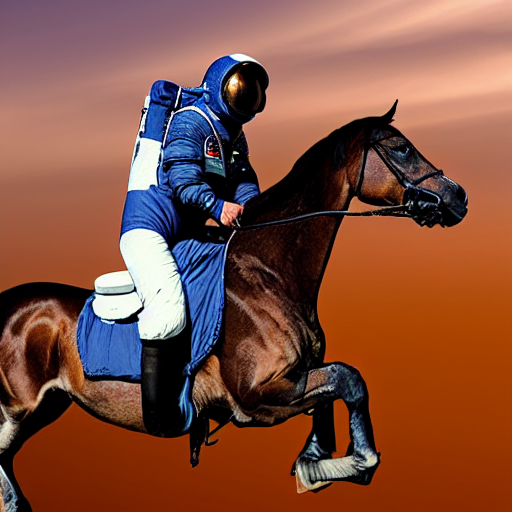

In [15]:
from torchvision.transforms import ToPILImage


pil_img = (image / 2 + 0.5).clamp(0, 1)
pil_img = pil_img.detach().cpu()
pil_img = ToPILImage()(pil_img[0]) 
pil_img

## Testing simple concept

In [31]:
a = torch.randn(5, 2, requires_grad=True)
b = torch.randn(5, 2)

c = torch.cat([a, b])

h = c.sum()
h.backward()

In [32]:
a.grad

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])